In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

from lateral_connections import VggLateral

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
m = VggLateral('MNIST')
m

VggLateral(
  (features): Sequential(
    (pool1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (lcl1): LaterallyConnectedLayer(4, (64, 112, 112), d=2, disabled=True, update=True)
    (pool2): Sequential(
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (lcl2): LaterallyConnectedLayer(4, (128, 56, 56), d=2, disabled=True, update=True)
    (pool3): Sequential(
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(i

### Utility functions and classes

In [3]:
def plot_images(imgs, num_images=8):
    
    fig, axs = plt.subplots(1, num_images, figsize=(3*num_images, 3))
    
    for i in range(num_images):
        axs[i].imshow(imgs[i][0,...])
    
    plt.tight_layout()
    plt.show()
    
def plot_loader(loader, num_images=8):
    imgs, _ = next(iter(loader))
    plot_images(imgs, num_images=num_images)
    
class MNIST_C_Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index], mode='L')
            x = self.transform(x)
            
        return x,y

    def __len__(self):
        return len(self.data)

### Pre-trained MNIST Test Accuracy

Evaluating MNIST test data.: 100%|█████████████████████████████████████████████████| 313/313 [00:43<00:00,  7.18it/s]

acc:	 0.9928


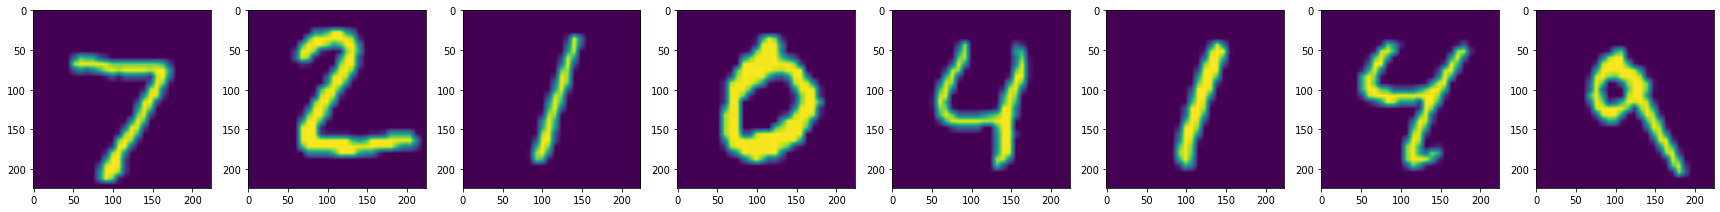

In [18]:
acc = m.test()
print('acc:\t', acc)

plot_loader(m.test_loader)

### Pre-trained MNIST-C Test Accuracy

Evaluating MNIST test data.: 100%|█████████████████████████████████████████████████| 313/313 [00:46<00:00,  6.80it/s]


MNIST-C 'line':		Accuracy: 0.8876


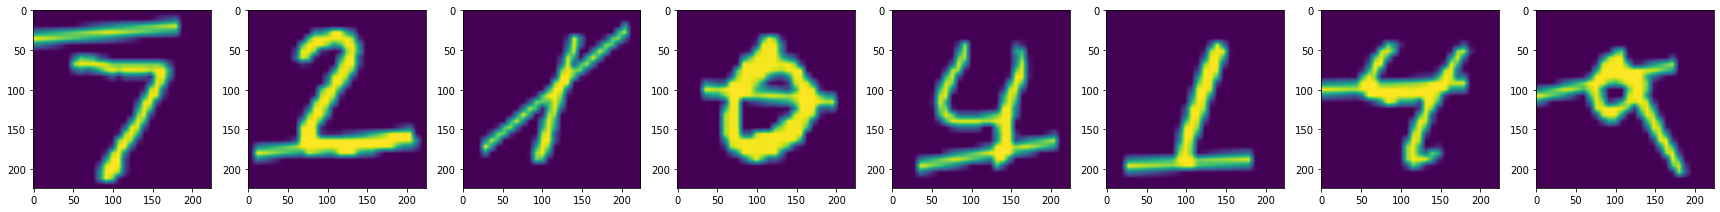

In [13]:
dirname = 'line'
root = 'images/mnist_c/' + dirname

imgs = np.load(root + '/test_images.npy')
imgs = imgs.transpose(0, 3, 1, 2)[:,0,...]
lbls = np.load(root + '/test_labels.npy').reshape((10000,))

# Transform Preprocessing
ds = MNIST_C_Dataset(imgs, lbls, transform=m.pretrained_vgg.test_transform)
dl = DataLoader(ds, batch_size=32, shuffle=False)

acc = m.test(dl)
print(f"MNIST-C '{dirname}':\t\tAccuracy: {acc:1.4f}")

plot_loader(dl)

### Initialized LCL MNIST Test Accuracy

In [16]:
m.features.lcl3.disabled=False
m.features.lcl3.update=False
acc = m.test()
print('acc:\t', acc)

Evaluating MNIST test data.: 100%|█████████████████████████████████████████████████| 313/313 [07:27<00:00,  1.43s/it]


0.9919

### LCL Training on MNIST Train Data

In [10]:
m.features.lcl3.disabled=False
m.features.lcl3.update=True

train_loader = torch.utils.data.DataLoader(m.pretrained_vgg.train_dataset, batch_size=16, shuffle=True, num_workers=1)
train_acc = m.test(train_loader)
print('train acc:\t', train_acc)

Evaluating MNIST test data.:   1%|▋                                             | 51/3750 [20:37<24:56:13, 24.27s/it]


KeyboardInterrupt: 

Evaluating MNIST test data.: 100%|███████████████████████████████████████████████| 2500/2500 [08:40<00:00,  4.81it/s]

MNIST-C 'line':		Accuracy: 0.8847


IndexError: index 4 is out of bounds for dimension 0 with size 4

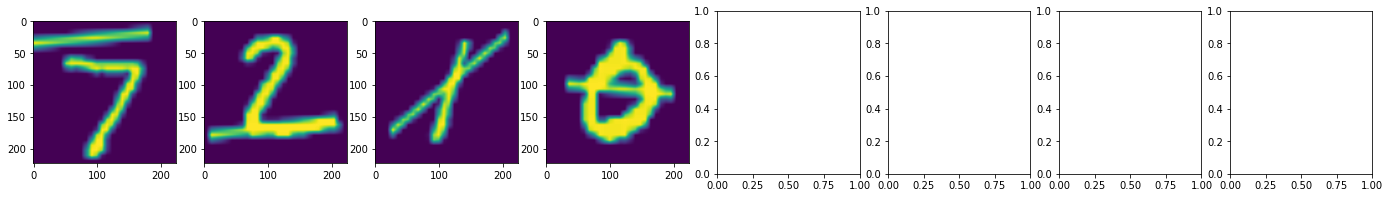

In [12]:
m.features.lcl3.disabled=False
m.features.lcl3.update=False

dirname = 'line'
root = 'images/mnist_c/' + dirname

imgs = np.load(root + '/test_images.npy')
imgs = imgs.transpose(0, 3, 1, 2)[:,0,...]
lbls = np.load(root + '/test_labels.npy').reshape((10000,))

# Transform Preprocessing
ds = MNIST_C_Dataset(imgs, lbls, transform=m.pretrained_vgg.test_transform)
dl = DataLoader(ds, batch_size=4, shuffle=False)

acc = m.test(dl)
print(f"MNIST-C '{dirname}':\t\tAccuracy: {acc:1.4f}")

plot_loader(dl)

In [14]:
m.features.lcl3.disabled=False
m.features.lcl3.update=False
test_loader = torch.utils.data.DataLoader(m.pretrained_vgg.test_dataset, batch_size=4, shuffle=True, num_workers=1)
acc = m.test(test_loader)
print('acc:\t', acc)

Evaluating MNIST test data.: 100%|███████████████████████████████████████████████| 2500/2500 [08:38<00:00,  4.82it/s]

acc:	 0.9918


In [18]:
m.features(torch.Tensor(imgs[0]))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 3, 3], but got 2-dimensional input of size [28, 28] instead